# Lab08 Anomaly Detection

## 1 - Packages

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

## 2 - Problem Statement

In this lab, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers.

The dataset contains two features:
- throughput (mb/s) and
- latency (ms) of response of each server.

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$.
- You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset.
- You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing.
- On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies.
- After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

## 3 - Dataset

You will start by loading the dataset for this task.
- The `load_data()` function shown below loads the data into the variables `X_train`, `X_val` and `y_val` .
  - You will use `X_train` to fit a Gaussian distribution.
  - You will use `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples.

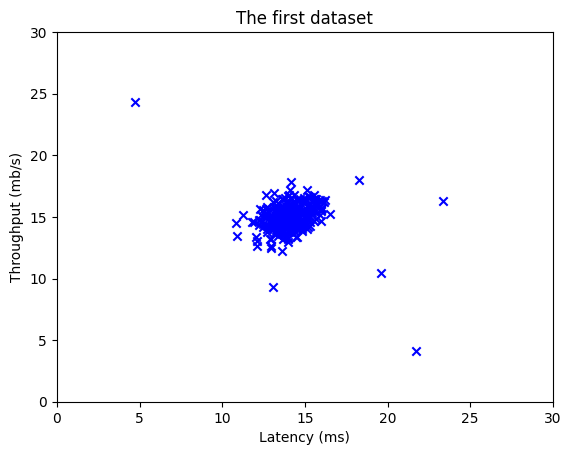

In [32]:
# Load the dataset

def load_data():
    X = np.load('X_2D.npy')
    X_val = np.load('X_val_2D.npy')
    y_val = np.load('y_val_2D.npy')
    return X, X_val, y_val


X_train, X_val, y_val = load_data()

# Visualize the data

plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b')
plt.title('The first dataset')
plt.ylabel('Throughput (mb/s)')
plt.xlabel('Latency (ms)')
plt.axis([0, 30, 0, 30])
plt.show()

## 4 - Gaussian Distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

- Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each of the features $x_i$.
- Recall that the Gaussian distribution is given by $$p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$ where $\mu$ is the mean and $\sigma^2$ is the variance.
- For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

You can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th feature by using the following equations.
$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [33]:
def estimate_gaussian(X):
    """
    Calculates mean and variance of all features in the dataset.

    Args:
        X (ndarray): (m, n) Data matrix

    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m = X.shape[0]

    mu = 1 / m * np.sum(X, axis=0)
    var = 1 / m * np.sum((X - mu) ** 2, axis=0)

    return mu, var

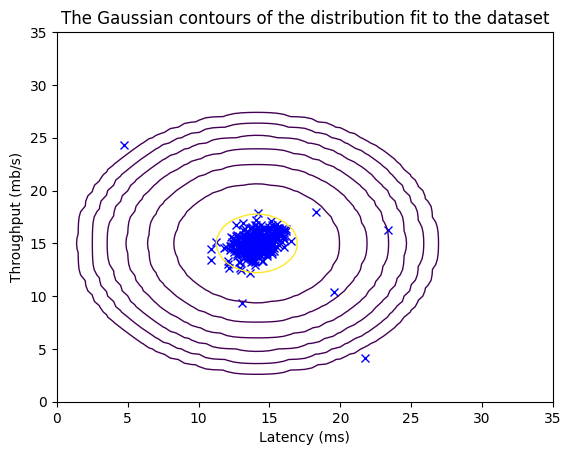

In [34]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)
p = multivariate_gaussian(X_train, mu, var)

# Plotting code
visualize_fit(X_train, mu, var)

# 5 - Selecting the Threshold $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability.

- The low probability examples are more likely to be the anomalies in our dataset.
- One way to determine which examples are anomalies is to select a threshold based on a cross validation set.

In this section, you will complete the code in `select_threshold` to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

- For this, we will use a cross validation set $\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example.
- For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`.
- The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

Please complete the `select_threshold` function below to find the best threshold to use for selecting outliers based on the results from the validation set ( `p_val` ) and the ground truth ( `y_val` ).

- In the provided code `select_threshold` , there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score.
- You need to implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`.
  - Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly.
  - Then, you can compute precision and recall by:
   $$
   \begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn}
   \end{aligned}
   $$ where
    - $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    - $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    - $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.
  - The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows: $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$

In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples.

In [35]:
def select_threshold(y_val, p_val):
    """
    Finds the best threshold to use for selecting outliers based on the results from a validation set (p_val) and the ground truth (y_val).

    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set

    Returns:
        epsilon (float): Threshold chosen
        F1 (float): F1 score by choosing epsilon as threshold
    """

    best_epsilon = 0
    best_F1 = 0
    F1 = 0

    step_size = (max(p_val) - min(p_val)) / 1000

    for epsilon in np.arange(min(p_val), max(p_val), step_size):

        predictions = (p_val < epsilon)

        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))

        prec = tp / (tp + fp)
        rec = tp / (tp + fn)

        F1 = 2 * prec * rec / (prec + rec)

        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon

    return best_epsilon, best_F1

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


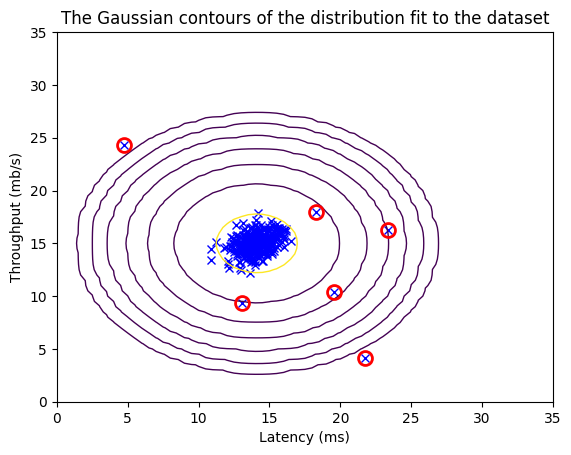

In [36]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

# Find the outliers in the training set
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro', markersize=10, markerfacecolor='none', markeredgewidth=2)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

## 6 - High Dimensional Dataset

Now, we will run the anomaly detection algorithm that you implemented on a more realistic and much harder dataset.

In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

- The `load_data()` function shown below loads the data into variables `X_train_high`, `X_val_high` and `y_val_high` .
  - `_high` is meant to distinguish these variables from the ones used in the previous part.
  - We will use `X_train_high` to fit Gaussian distribution.
  - We will use `X_val_high` and `y_val_high` as a cross validation set to select a threshold and determine anomalous vs normal examples.

In [37]:
# Load the dataset

def load_data_multi():
    X = np.load('X_11D.npy')
    X_val = np.load('X_val_11D.npy')
    y_val = np.load('y_val_11D.npy')
    return X, X_val, y_val


X_train_high, X_val_high, y_val_high = load_data_multi()

Run the anomaly detection algorithm on this new dataset.

In [38]:
# Apply the same steps to the larger dataset

mu_high, var_high = estimate_gaussian(X_train_high)
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e' % epsilon_high)
print('Best F1 on Cross Validation Set: %f' % F1_high)
print('Anomalies found: %d' % sum(p_high < epsilon_high))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set: 0.615385
Anomalies found: 117


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
